In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Input, Conv1D, SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout, Bidirectional, SimpleRNN, Attention, Activation, Dot, concatenate
from keras.models import Model
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1


In [4]:
metadata = pd.read_csv('/content/drive/MyDrive/archive (17)/bird_songs_metadata.csv')
metadata.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [5]:
# Lists for storing the filepaths and labels
file_paths = []
labels = []

audio_dir = '/content/drive/MyDrive/archive (17)/wavfiles/'

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    if os.path.exists(file_path):
        file_paths.append(file_path)
        labels.append(row['species'])

file_paths[:5], labels[:5]

(['/content/drive/MyDrive/archive (17)/wavfiles/557838-0.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-1.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-4.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-5.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-6.wav'],
 ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii'])

In [6]:
bird_labels = metadata['species']
bird_labels = bird_labels.values
bird_labels[bird_labels == ['bewickii']] = 0
bird_labels[bird_labels == ['polyglottos']] = 1
bird_labels[bird_labels == ['migratorius']] = 2
bird_labels[bird_labels == ['melodia']] = 3
bird_labels[bird_labels == ['cardinalis']] = 4
bird_labels = np.squeeze(bird_labels)

In [29]:
# Function to read audio file
def read_file(path):
    y, _ = librosa.load(path, sr=22050)  # Set the sample rate to ensure consistency
    return y

# Function to convert to dB scale
def spec_to_db(y):
    y_db = librosa.power_to_db(y, ref=np.max)
    #y_db = librosa.amplitude_to_db(y, ref=100)
    return y_db

# Map function that returns spectrograms
def map_function(path_tensor, label):
    # Load audio file
    y = tf.numpy_function(read_file, inp=[path_tensor], Tout=tf.float32)

    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))

    # Convert to Mel spectrogram
    mel_weights = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=tf.shape(spectrogram)[-1],
        sample_rate=22050,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0)
    mel_spectrogram = tf.matmul(spectrogram, mel_weights)

    # Compute MFCCs from Mel spectrogram
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(tf.math.log(mel_spectrogram + 1e-6))  # Adding a small epsilon to avoid log(0)

    return mfccs, label


def make_dataset(bird_labels, file_paths, shuffle):
    bird_labels = tf.convert_to_tensor(bird_labels, dtype = tf.int32)
    file_paths = tf.convert_to_tensor(file_paths, dtype = tf.string)

    bird_labels = tf.data.Dataset.from_tensor_slices(bird_labels)
    file_paths = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = tf.data.Dataset.zip( file_paths, bird_labels)

    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_function, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size = 64, num_parallel_calls = tf.data.AUTOTUNE, drop_remainder = True)

    return dataset

In [30]:
file_paths_train, file_paths_test, y_train, y_test = train_test_split(
    file_paths, bird_labels, test_size=0.20, random_state=42)

dataset_train = make_dataset(y_train, file_paths_train, shuffle=True)
dataset_test = make_dataset(y_test, file_paths_test, shuffle=False)

for batch in dataset_train.take(1):
    input_data_shape = batch[0].shape
print("Shape of input data in training dataset:", input_data_shape)

Shape of input data in training dataset: (64, 1026, 128)


In [31]:
def create_model():
    inputs = Input(shape=(1026, 128), name='0_Input_shape')

    x = Conv1D(64, 8, 2, activation='relu', padding='same', name='1_Conv1D')(inputs)
    x = SpatialDropout1D(0.17, name='2_SpatialDropout1D')(x)

    x = Conv1D(64, 8, 2, activation='relu', padding='same', name='3_Conv1d')(x)
    x = SpatialDropout1D(0.17, name='4_SpatialDropout1D')(x)

    x = Conv1D(64, 8, 2, activation='relu', padding='same', name='5_Conv1d')(x)
    x = SpatialDropout1D(0.17, name='6_SpatialDropout1D')(x)

    x = Conv1D(64, 8, 2, activation='relu', padding='same', name='7_Conv1d')(x)
    x = SpatialDropout1D(0.17, name='8_SpatialDropout1D')(x)

    x = GlobalAveragePooling1D(name='9_Global_avg_pooling')(x)
    x = Dense(512, activation='relu', name='10_Dense')(x)
    x = Dropout(0.5, name='11_Dropout')(x)

    outputs = Dense(5, name='12_Dense')(x)
    model = Model(inputs=inputs, outputs=outputs, name='Bird_audio_classification_model')

    return model

In [32]:
model = create_model()
model.summary()

Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Input_shape (InputLayer)  [(None, 1026, 128)]       0         
                                                                 
 1_Conv1D (Conv1D)           (None, 513, 64)           65600     
                                                                 
 2_SpatialDropout1D (Spatia  (None, 513, 64)           0         
 lDropout1D)                                                     
                                                                 
 3_Conv1d (Conv1D)           (None, 257, 64)           32832     
                                                                 
 4_SpatialDropout1D (Spatia  (None, 257, 64)           0         
 lDropout1D)                                                     
                                                                 
 5_Conv1d (Conv1D)           (None,

In [33]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps= 4000, decay_rate = 0.5, staircase=False, name=None)

model.compile(optimizer = Adam(lr_schedule),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = [ SparseCategoricalAccuracy()])

In [34]:
# Creating callbacks
logdir = 'tb_logs/model'
tensorboard_callback = TensorBoard(log_dir=logdir)

checkpoint_filepath = 'model_checkpoint/model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [35]:
training = model.fit(dataset_train, validation_data = dataset_test, epochs=120,
                    callbacks=[tensorboard_callback,model_checkpoint_callback])


Epoch 1/120
67/67 [==============================] - ETA: 0s - loss: 1.5770 - sparse_categorical_accuracy: 0.2635

67/67 [==============================] - 563s 8s/step - loss: 1.5770 - sparse_categorical_accuracy: 0.2635 - val_loss: 1.3316 - val_sparse_categorical_accuracy: 0.3477
Epoch 2/120
67/67 [==============================] - ETA: 0s - loss: 1.3025 - sparse_categorical_accuracy: 0.3876

67/67 [==============================] - 19s 279ms/step - loss: 1.3025 - sparse_categorical_accuracy: 0.3876 - val_loss: 1.1425 - val_sparse_categorical_accuracy: 0.4824
Epoch 3/120
67/67 [==============================] - 20s 304ms/step - loss: 1.1809 - sparse_categorical_accuracy: 0.4608 - val_loss: 1.0250 - val_sparse_categorical_accuracy: 0.5273
Epoch 4/120
67/67 [==============================] - 17s 247ms/step - loss: 1.0788 - sparse_categorical_accuracy: 0.5175 - val_loss: 1.0109 - val_sparse_categorical_accuracy: 0.4688
Epoch 5/120
67/67 [==============================] - 19s 280ms/step - loss: 1.0360 - sparse_categorical_accuracy: 0.5403 - val_loss: 0.9274 - val_sparse_categorical_accuracy: 0.5645
Epoch 6/120
67/67 [==============================] - 20s 297ms/step - loss: 0.9729 - sparse_categorical_accuracy: 0.5854 - val_loss: 0.9632 - val_sparse_categorical_accuracy: 0.5811
Epoch 7/120
67/67 [==============================] - 20s 300ms/step - loss: 0.9743 - sparse_categorica

In [36]:
y_logits = model.predict(dataset_test)
y_prob = tf.nn.softmax(y_logits, axis=1)
y_pred = tf.argmax(y_logits, axis=1)
y_true = tf.concat(list(dataset_test.map(lambda s,lab: lab)), axis=0)

16/16 [==============================] - 4s 233ms/step


In [37]:
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovo')
print(f"F1: {f1} | Precision: {precision} | Recall: {recall} | AUC: {auc}")

F1: 0.913582045912994 | Precision: 0.916244598891845 | Recall: 0.9141328221061974 | AUC: 0.9929787461716323


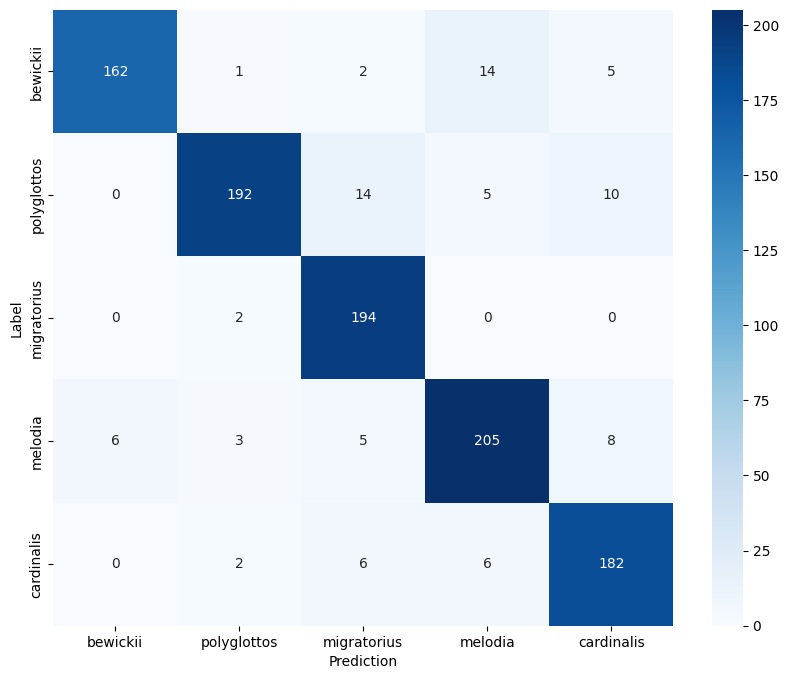

In [38]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            yticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            annot=True, fmt='g', cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [39]:
import zipfile

def zip_file(file_to_zip, zip_file_name):
    with zipfile.ZipFile(zip_file_name, 'w') as zipf:
        zipf.write(file_to_zip, arcname=file_to_zip)

# Example usage:
file_to_zip = '/content/model_checkpoint/model'
zip_file_name = '/model_MFCC_CNN.zip'

zip_file(file_to_zip, zip_file_name)